# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/zakariaabou/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 93 (delta 27), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (93/93), 892.98 KiB | 2.75 MiB/s, done.
Resolving deltas: 100% (27/27), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


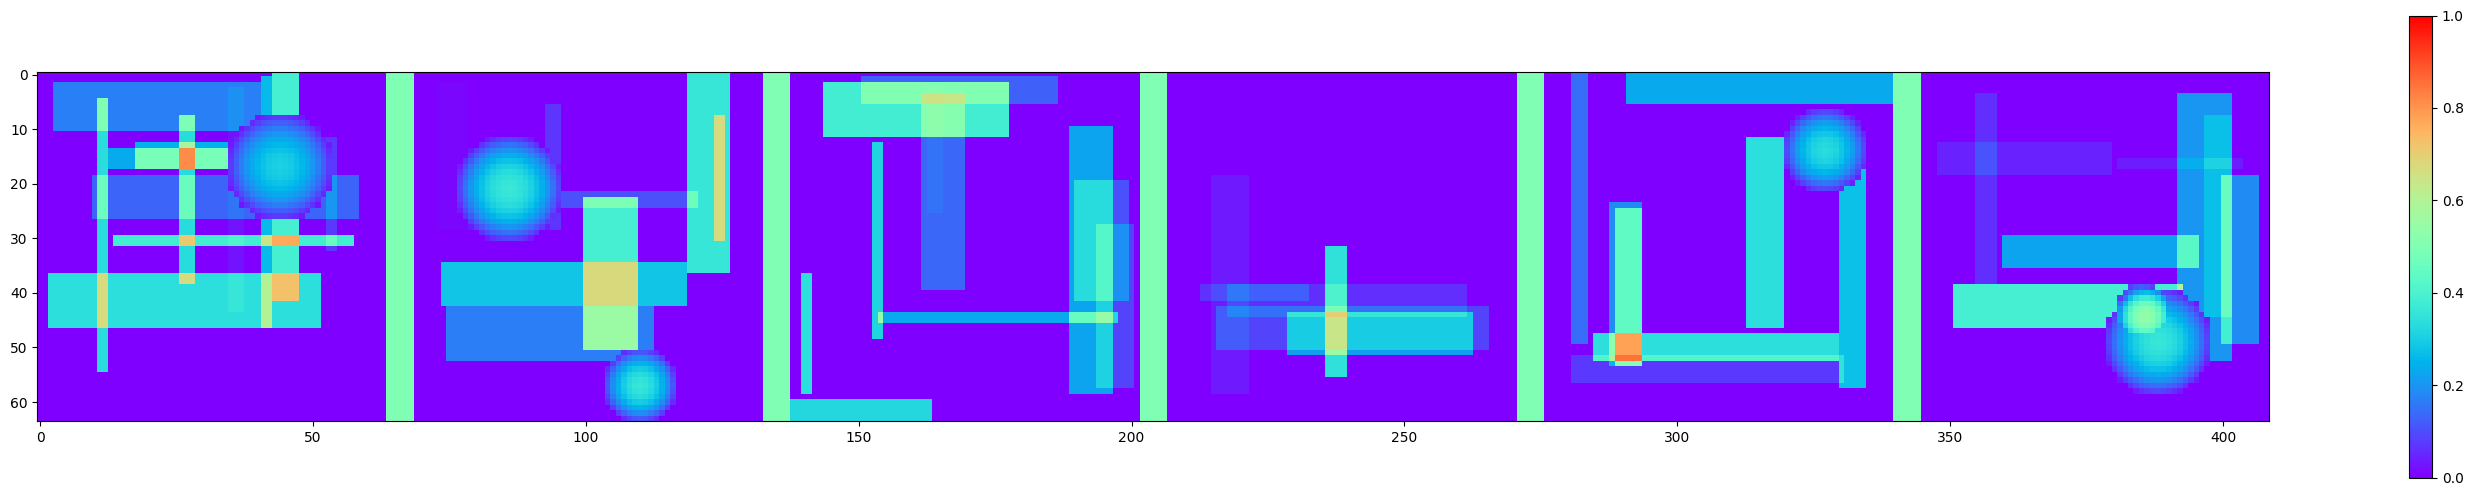

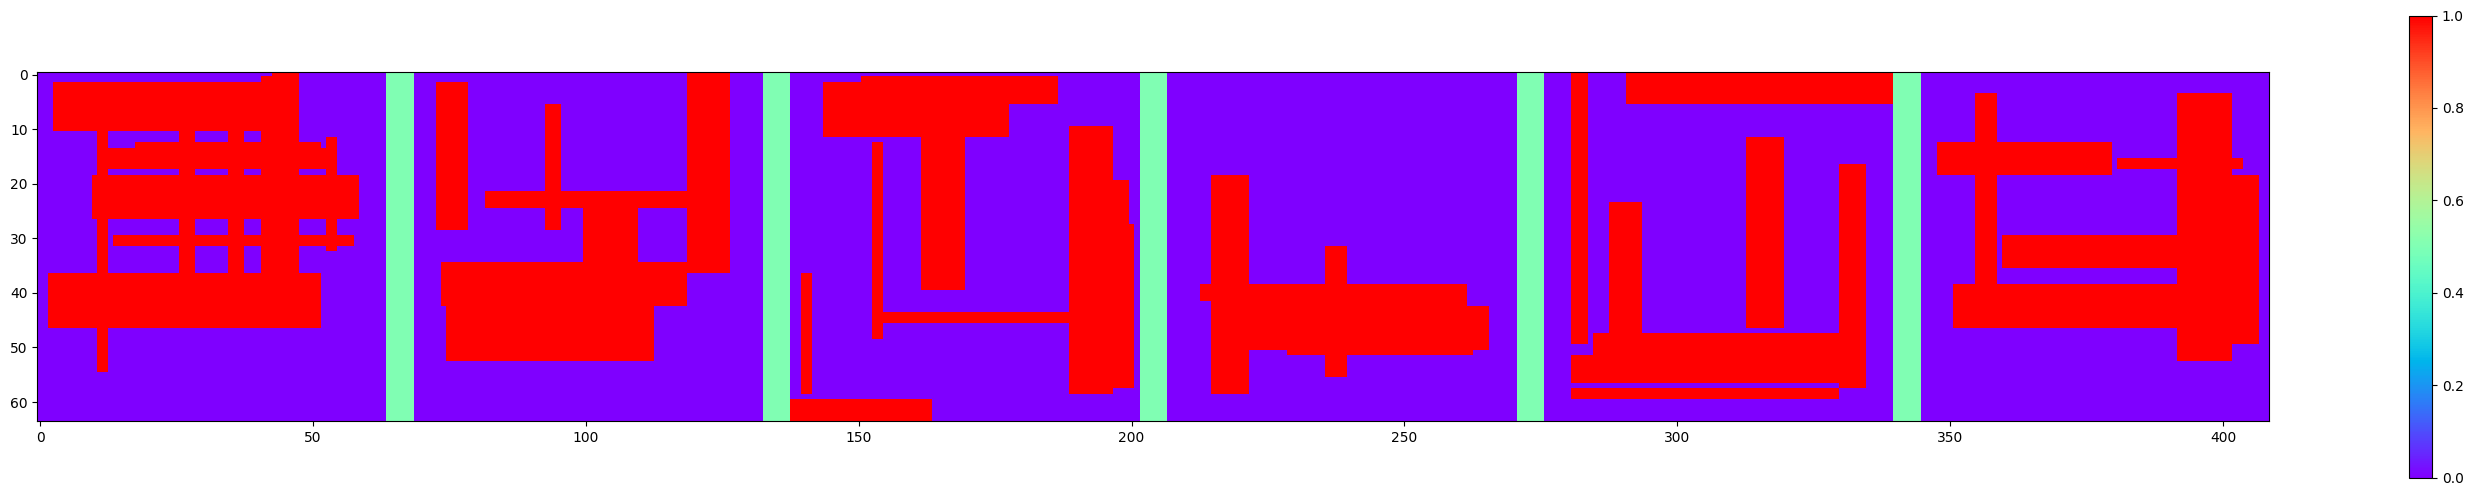

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

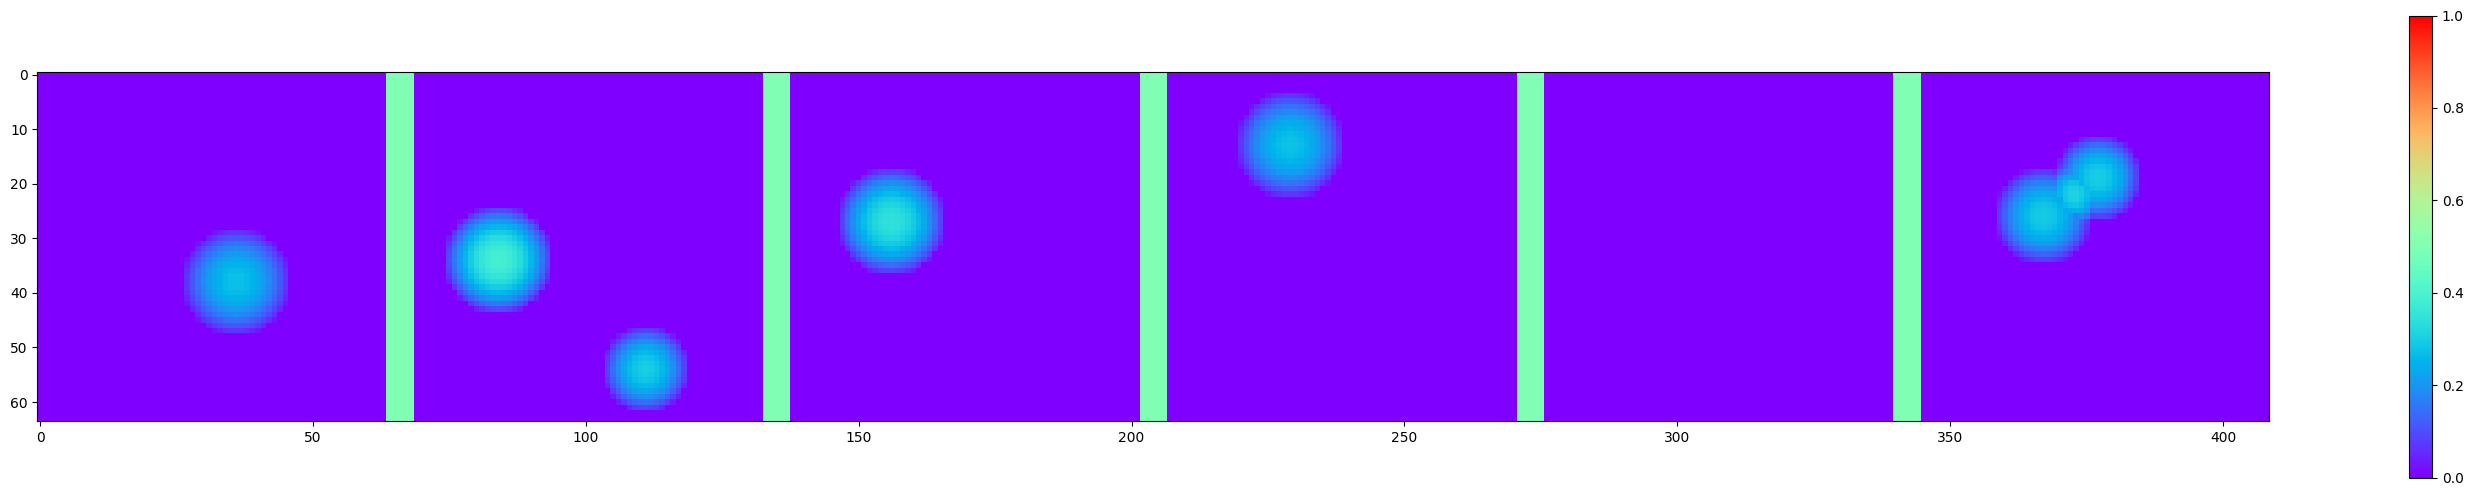

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

La supervision faible consiste à apprendre à partir de données partiellement étiquetées, bruitées ou imprécises. Dans cet exercice, la segmentation doit être effectuée sur des images corrompues (avec des disques ajoutés comme bruit), sans disposer d'une cible idéale précise. Cela correspond à un cas de supervision faible, car la cible idéale (sans bruit) n'est pas disponible, et le modèle doit apprendre à partir des données corrompues.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Génération des données d'entraînement
inputs, ideal_targets = gen_dr(1000)  # Générer 1000 images pour l'entraînement

# Si `inputs` et `ideal_targets` sont déjà des tensors, vous pouvez directement les déplacer vers le GPU
inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
ideal_targets = torch.tensor(ideal_targets, dtype=torch.float32).to(device)

# Création du DataLoader
dataset = TensorDataset(inputs, ideal_targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Définition du modèle UNet et déplacement vers le GPU
model = UNet(n_channels=1, n_classes=1).to(device)  # 1 canal d'entrée, 1 classe de sortie

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 50
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)  # Déplacement vers le GPU
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

<ipython-input-7-00ec5aa5eb0b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
<ipython-input-7-00ec5aa5eb0b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ideal_targets = torch.tensor(ideal_targets, dtype=torch.float32).to(device)


Epoch 1/50, Loss: 0.17833371460437775
Epoch 2/50, Loss: 0.08521220088005066
Epoch 3/50, Loss: 0.04361219331622124
Epoch 4/50, Loss: 0.07449658215045929
Epoch 5/50, Loss: 0.037710174918174744
Epoch 6/50, Loss: 0.07246339321136475
Epoch 7/50, Loss: 0.052061937749385834
Epoch 8/50, Loss: 0.026891641318798065
Epoch 9/50, Loss: 0.07507233321666718
Epoch 10/50, Loss: 0.1067051962018013
Epoch 11/50, Loss: 0.037233807146549225
Epoch 12/50, Loss: 0.020746320486068726
Epoch 13/50, Loss: 0.035056568682193756
Epoch 14/50, Loss: 0.008105725049972534
Epoch 15/50, Loss: 0.02655598893761635
Epoch 16/50, Loss: 0.016468452289700508
Epoch 17/50, Loss: 0.017408335581421852
Epoch 18/50, Loss: 0.01751677691936493
Epoch 19/50, Loss: 0.029318291693925858
Epoch 20/50, Loss: 0.029880955815315247
Epoch 21/50, Loss: 0.025310585275292397
Epoch 22/50, Loss: 0.026786839589476585
Epoch 23/50, Loss: 0.0266900472342968
Epoch 24/50, Loss: 0.00813262164592743
Epoch 25/50, Loss: 0.011212138459086418
Epoch 26/50, Loss: 0.0

<ipython-input-8-ea566748942a>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs, dtype=torch.float32).clone().detach().to(device)


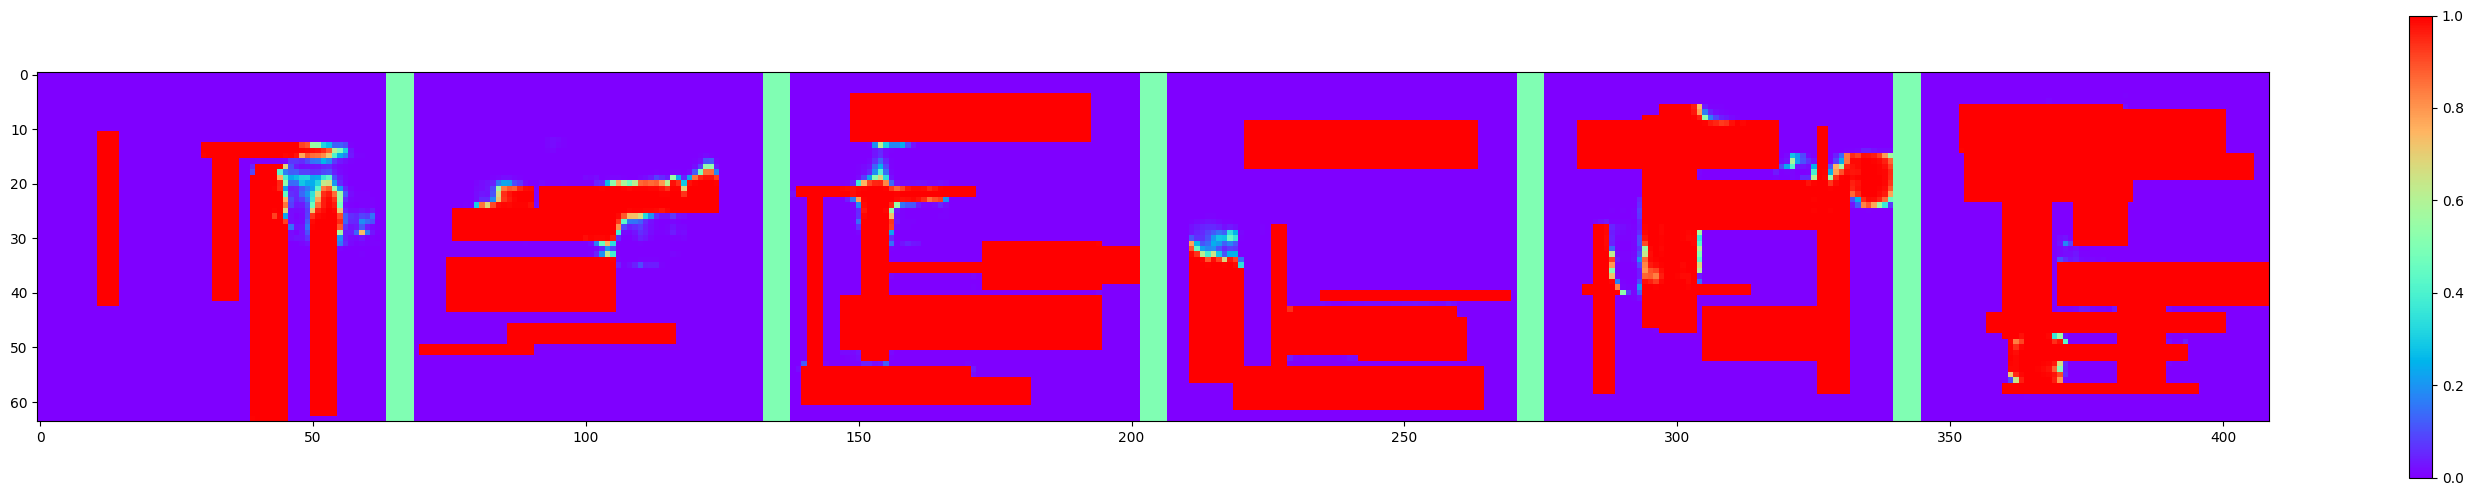

In [8]:
# Visualisation des résultats après entraînement
test_inputs, _ = gen_dr(6)

# Utilisation de clone().detach() pour éviter le warning
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).clone().detach().to(device)

with torch.no_grad():
    predicted = model(test_inputs)
    predicted = torch.sigmoid(predicted)  # Convertir les logits en probabilités

# Déplacer les résultats du GPU vers le CPU et convertir en tensor PyTorch
predicted = predicted.cpu()  # Déplacer vers le CPU sans la conversion en NumPy

# Affichage des résultats
fig = plt.figure(figsize=(36, 6))
voir_batch2D(predicted, 6, fig, k=0, min_scale=0, max_scale=1)

\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([6.3334, 2.2811, 4.8366, 5.1402, 4.2456, 6.5763])


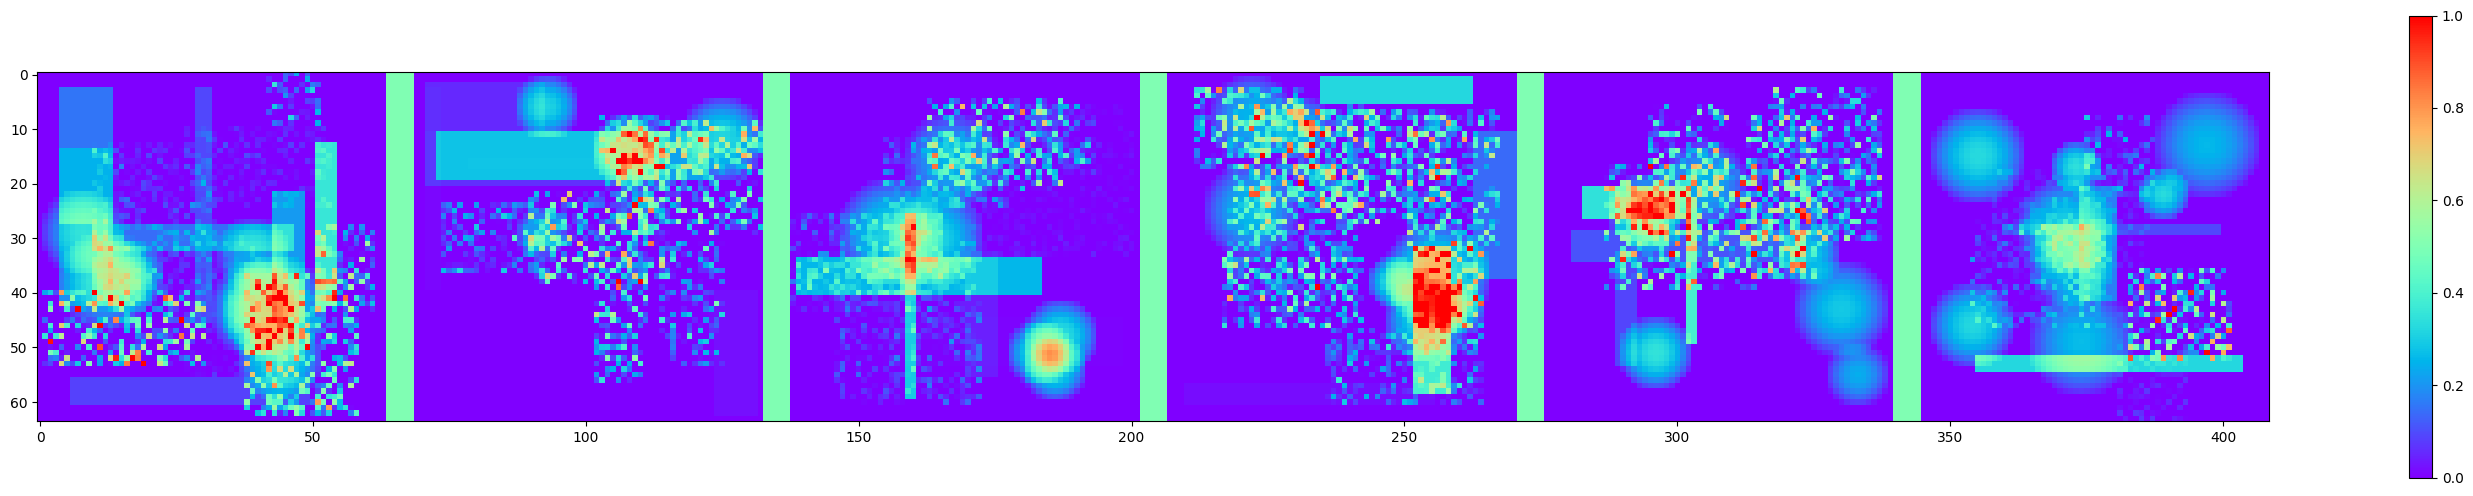

tensor([6.4832, 0.6172, 5.9186, 5.3246, 5.0793, 7.2271])


In [9]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# Génération des données
inputs, targets = gen_ex2(1000)  # Générer 1000 échantillons
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# Création du DataLoader
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

tensor([12.7972,  6.7110,  7.5741,  5.4869,  4.6295,  6.5604,  4.6948,  3.9693,
         4.8019,  2.2677,  3.5075,  1.3030,  4.1973,  3.1317,  6.5031,  3.8703,
         6.8141,  3.7590,  4.8122,  9.3075,  6.4996,  3.1354,  5.0185,  2.1043,
         3.4190,  4.1901,  4.5598,  3.9750,  3.6771,  8.4922,  4.2387,  8.2928,
         6.6613,  4.0572,  4.2084,  3.3570,  5.5602,  7.1802,  4.0035,  2.2780,
         2.7535,  2.2686,  7.0125,  2.0814,  9.0126,  7.8800,  4.8816,  4.9483,
         3.9549,  3.8374,  4.9625,  2.6787,  3.0241,  9.4725,  4.9895,  4.6041,
         1.7145,  1.9842,  4.8314,  6.7351,  3.6121,  4.5676,  6.0128,  3.1620,
         5.5744,  4.6506,  7.6392,  1.4455,  6.1833,  6.7985,  5.6157,  2.1667,
         3.9220,  5.3607,  3.1711,  1.8690,  3.4038,  4.6647,  4.4708,  1.1218,
         6.4267,  7.9803,  4.9175,  2.6675,  4.6239,  2.5148,  2.1430,  3.1477,
         7.5040,  7.2069,  5.3661,  6.3971,  4.7435,  6.5774,  4.4837,  5.6006,
         6.7806,  9.8389,  3.1442,  2.62

<ipython-input-10-36333ec5ab70>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-10-36333ec5ab70>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [11]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement du modèle ResNet18
model = resnet18(pretrained=False)

# Modifier la première couche pour accepter 1 canal (image en niveaux de gris)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modifier la dernière couche pour la régression
model.fc = nn.Linear(model.fc.in_features, 1)

# Déplacer le modèle vers le périphérique approprié (GPU ou CPU)
model = model.to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.L1Loss()  # Loss pour la médiane
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 20
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Déplacer les données d'entrée et les cibles vers le périphérique
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        # Réduire la dimension des cibles pour correspondre à la sortie du modèle (batch_size, 1)
        batch_targets = batch_targets.view(batch_targets.size(0), -1)  # Aplatir les cibles à la forme (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20, Loss: 1.3900028467178345
Epoch 2/20, Loss: 1.5568625926971436
Epoch 3/20, Loss: 1.3543977737426758
Epoch 4/20, Loss: 1.3031771183013916
Epoch 5/20, Loss: 0.6765273809432983
Epoch 6/20, Loss: 1.5743277072906494
Epoch 7/20, Loss: 1.2133021354675293
Epoch 8/20, Loss: 0.794508695602417
Epoch 9/20, Loss: 1.2019553184509277
Epoch 10/20, Loss: 1.3042271137237549
Epoch 11/20, Loss: 0.576280415058136
Epoch 12/20, Loss: 1.2912304401397705
Epoch 13/20, Loss: 0.926258385181427
Epoch 14/20, Loss: 0.6820335388183594
Epoch 15/20, Loss: 1.0248024463653564
Epoch 16/20, Loss: 0.6173626184463501
Epoch 17/20, Loss: 0.954484224319458
Epoch 18/20, Loss: 0.4990333318710327
Epoch 19/20, Loss: 0.557743489742279
Epoch 20/20, Loss: 0.4158233404159546


**Justification de l'absence de validation :** Dans ce cas, les données sont générées de manière synthétique et ne présentent pas de risque de sur-apprentissage. Par conséquent, une étape de validation n'est pas nécessaire.

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement du modèle ResNet18
model = resnet18(pretrained=False)

# Modifier la première couche pour accepter 1 canal (image en niveaux de gris)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modifier la dernière couche pour prédire 3 sorties (premier quartile, médiane, troisième quartile)
model.fc = nn.Linear(model.fc.in_features, 3)

# Déplacer le modèle vers le périphérique (GPU ou CPU)
model = model.to(device)

# Définition de la fonction de perte pour la régression quantile
def quantile_loss(outputs, targets, quantiles=[0.25, 0.5, 0.75]):
    losses = []
    for i, q in enumerate(quantiles):
        errors = targets - outputs[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

# Fonction pour calculer les quantiles
def calculate_quantiles(tensor, quantiles=[0.25, 0.5, 0.75]):
    quantiles_values = []
    for q in quantiles:
        quantiles_values.append(torch.quantile(tensor.view(tensor.size(0), -1), q, dim=1))
    return torch.stack(quantiles_values, dim=1).T  # (batch_size, 3)

# Définition de l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 20
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Déplacer les données d'entrée et les cibles vers le périphérique
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        # Calculer les quantiles des cibles si elles sont sous forme d'images
        batch_targets = calculate_quantiles(batch_targets)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = quantile_loss(outputs, batch_targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/20, Loss: 2.789036512374878
Epoch 2/20, Loss: 1.3320677280426025
Epoch 3/20, Loss: 1.6694073677062988
Epoch 4/20, Loss: 1.9050811529159546
Epoch 5/20, Loss: 1.7216938734054565
Epoch 6/20, Loss: 0.9284374117851257
Epoch 7/20, Loss: 1.6473166942596436
Epoch 8/20, Loss: 0.9746946096420288
Epoch 9/20, Loss: 1.6256053447723389
Epoch 10/20, Loss: 1.3461601734161377
Epoch 11/20, Loss: 0.5187979936599731
Epoch 12/20, Loss: 0.6153565645217896
Epoch 13/20, Loss: 0.9617090225219727
Epoch 14/20, Loss: 0.839812159538269
Epoch 15/20, Loss: 1.2480297088623047
Epoch 16/20, Loss: 0.9622837901115417
Epoch 17/20, Loss: 0.8212582468986511
Epoch 18/20, Loss: 1.0908501148223877
Epoch 19/20, Loss: 0.7844623923301697
Epoch 20/20, Loss: 1.472888708114624


**Fonction de coût utilisée :** La fonction de perte utilisée est la perte de régression quantile, qui est adaptée pour prédire les quantiles (premier quartile, médiane, troisième quartile).

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

In [13]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Génération d'un batch de test
test_inputs, test_targets = gen_ex2(64)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)  # Déplacer test_inputs vers le périphérique
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)  # Déplacer test_targets vers le périphérique

# Prédiction des quantiles
with torch.no_grad():
    outputs = model(test_inputs)
    q1, q2, q3 = outputs[:, 0], outputs[:, 1], outputs[:, 2]

# Calcul des écarts interquartiles
iqr = q3 - q1
print("Écarts interquartiles :", iqr)

tensor([3.2299, 4.9826, 7.7040, 4.0935, 4.4627, 6.9760, 5.5784, 5.4389, 4.2767,
        4.3075, 6.3576, 3.2648, 6.5645, 1.6655, 4.4450, 3.4495, 0.8987, 7.4406,
        5.3150, 3.9674, 1.8460, 4.8976, 2.7737, 3.1381, 2.6486, 7.2588, 3.3150,
        3.9396, 5.8901, 2.3752, 3.9510, 3.3816, 4.1672, 4.5275, 4.6114, 3.4363,
        2.2098, 4.1573, 3.1770, 5.3896, 1.0336, 6.3189, 6.9257, 6.0240, 4.6988,
        4.4252, 5.7080, 4.8608, 5.4705, 6.6859, 2.3012, 6.1708, 3.8948, 2.0124,
        4.4436, 4.2823, 2.0304, 6.0525, 0.6854, 2.6067, 7.4789, 4.7812, 2.1314,
        4.3030])
Écarts interquartiles : tensor([0.9499, 1.5871, 1.5195, 1.1626, 1.1251, 1.4511, 1.0555, 1.0340, 1.0371,
        1.2541, 1.5149, 1.0487, 1.4619, 1.0657, 1.2649, 1.1285, 1.1136, 1.4787,
        1.3795, 1.1730, 1.0488, 1.1918, 1.0532, 1.0815, 1.0317, 1.3219, 1.2347,
        1.1690, 1.9611, 1.2233, 0.9351, 0.9937, 1.2571, 0.9741, 1.4244, 1.1105,
        1.1997, 1.0416, 0.9728, 1.1588, 0.8671, 1.0799, 1.3109, 1.3991, 1.2762,

<ipython-input-13-5342538da450>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)  # Déplacer test_inputs vers le périphérique
<ipython-input-13-5342538da450>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)  # Déplacer test_targets vers le périphérique


**Observation :** Les écarts interquartiles peuvent varier en fonction de l'image d'entrée, ce qui suggère que l'incertitude de la prédiction dépend des caractéristiques de l'image.

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

Pour tester cette hypothèse, on pourrait entraîner un modèle uniquement sur les images générées par gen_d (uniquement des disques) et évaluer ses performances sur les images de gen_ex2. Si le modèle performe bien, cela suggère que les disques sont suffisants pour prédire la sortie. Sinon, cela indique que d'autres éléments (comme les rectangles) jouent un rôle important.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

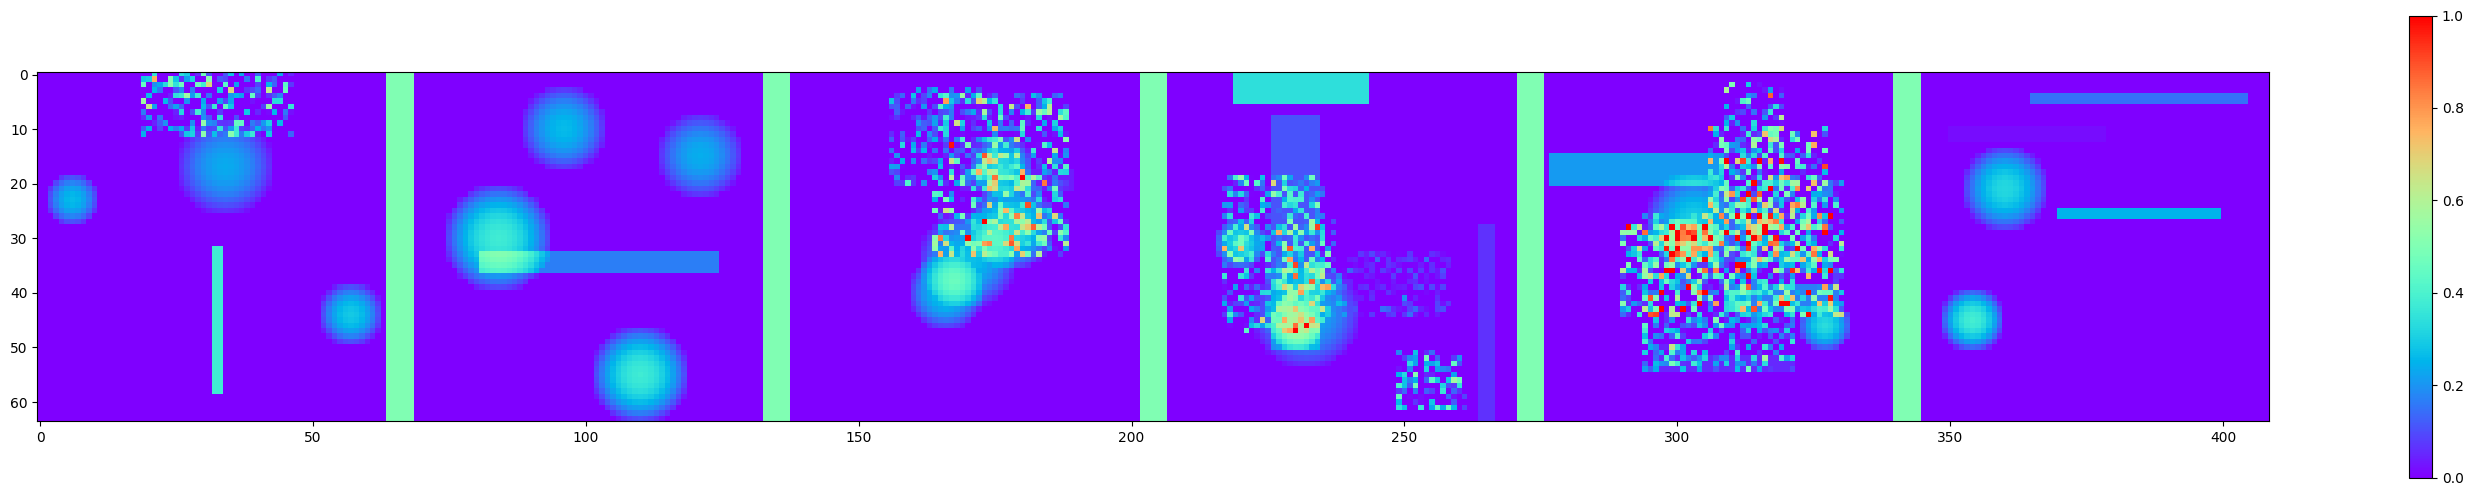

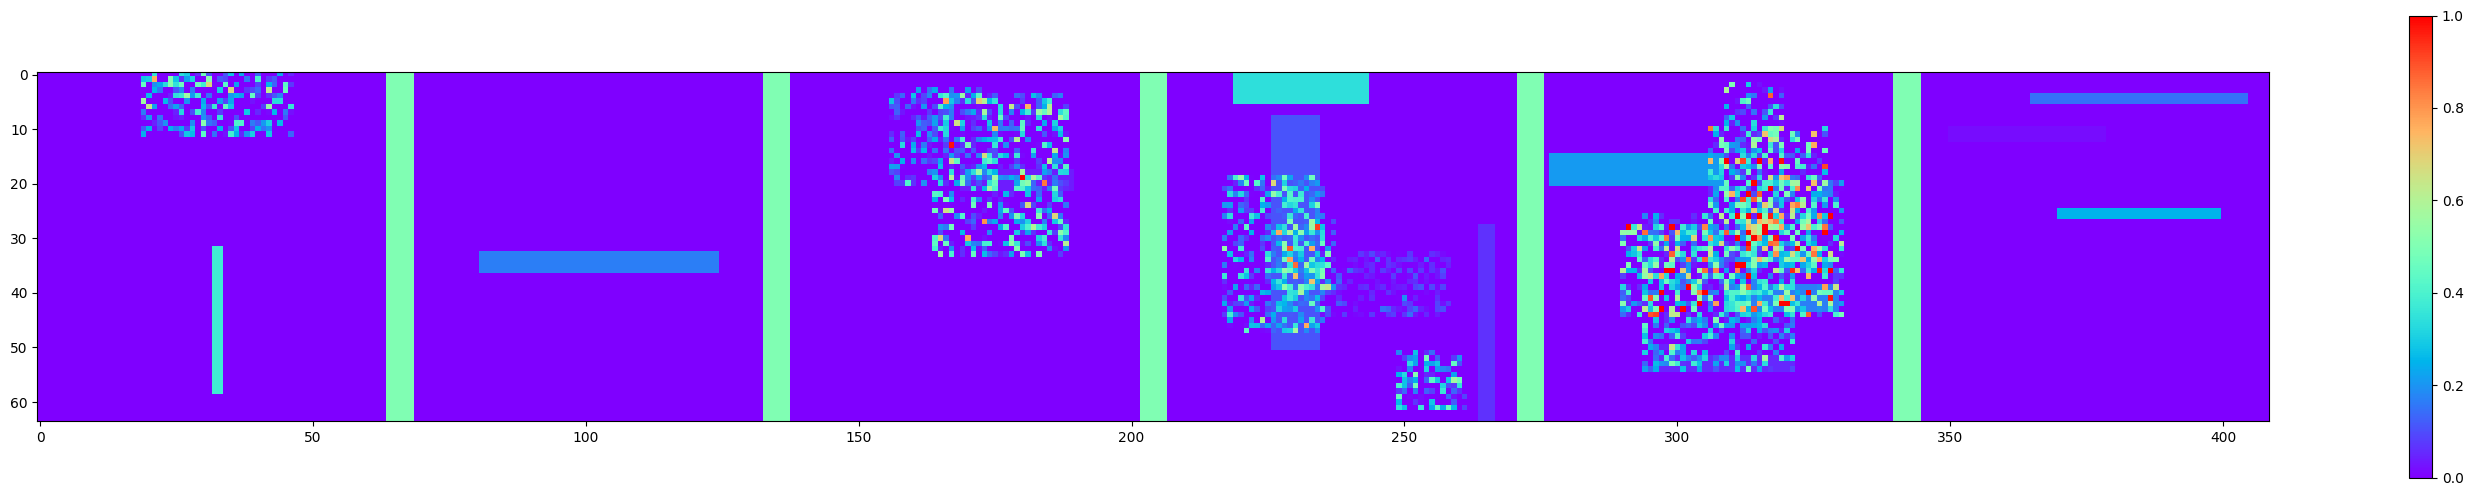

In [14]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

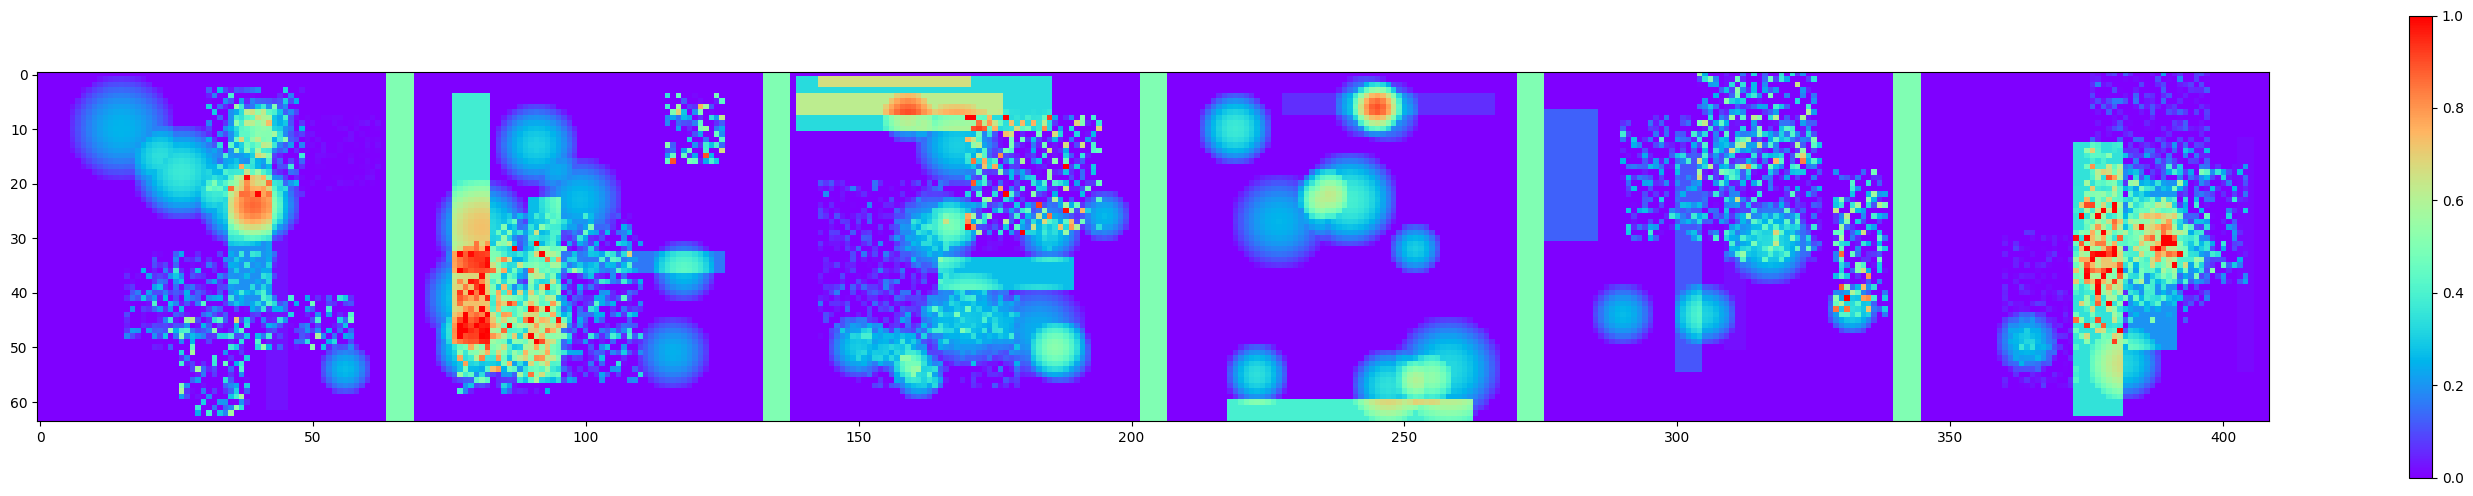

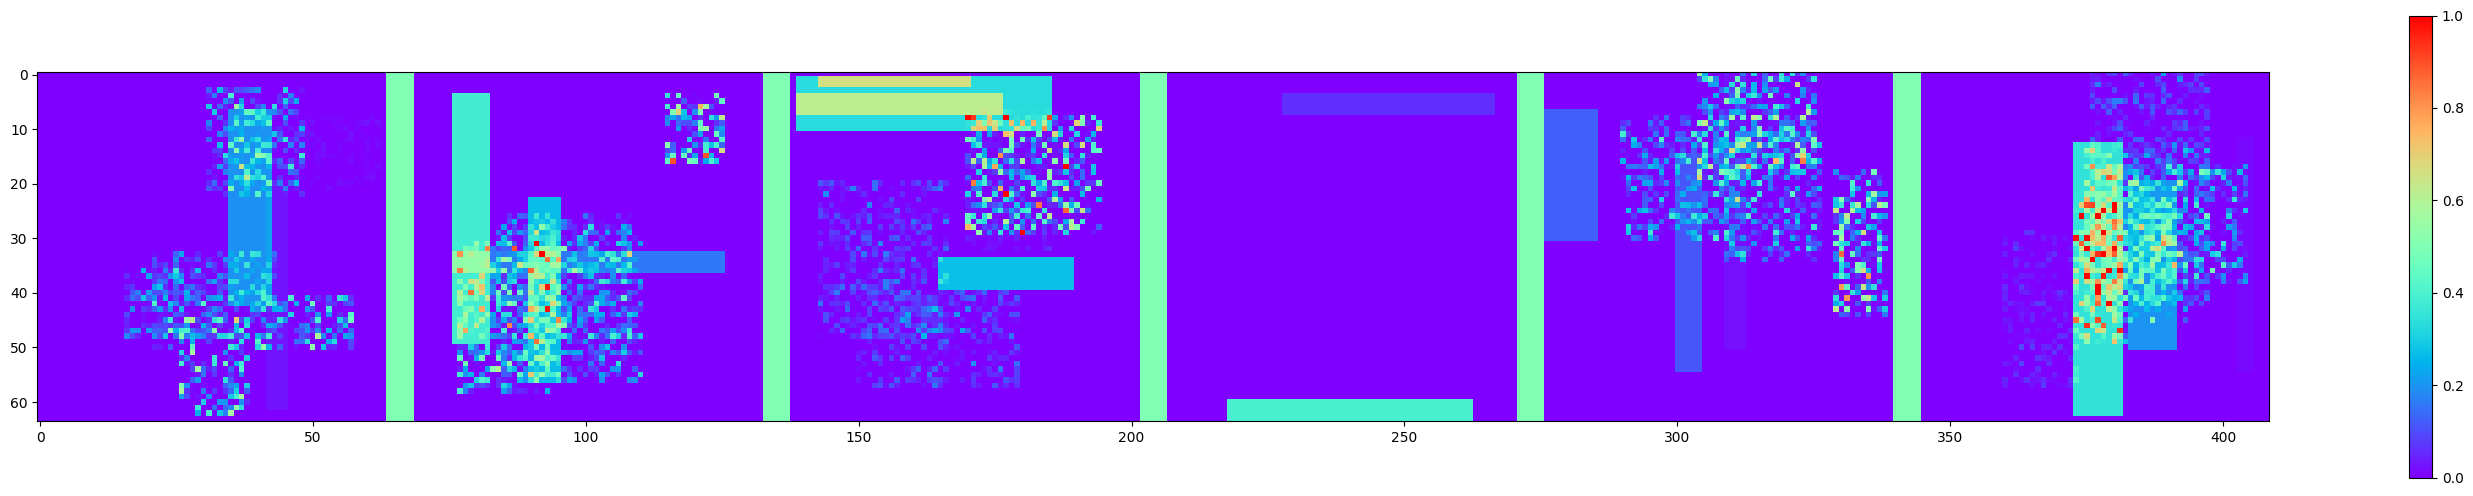

In [15]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

La domain adaptation (adaptation de domaine) est une technique utilisée pour adapter un modèle entraîné sur un domaine source (par exemple, des images avec certaines caractéristiques) à un domaine cible (des images avec des caractéristiques différentes). Dans ce problème, les données d'entraînement (gen_dr_train) et de test (gen_dr_test) ont des distributions différentes, ce qui nécessite une adaptation de domaine pour améliorer les performances sur les données de test.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Génération d'un batch d'entraînement
train_inputs, train_targets = gen_dr_train(1000)
train_inputs = torch.tensor(train_inputs, dtype=torch.float32).to(device)  # Déplacer vers le périphérique
train_targets = torch.tensor(train_targets, dtype=torch.float32).to(device)  # Déplacer vers le périphérique

# Création du DataLoader
train_dataset = TensorDataset(train_inputs, train_targets)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialisation du modèle UNet et déplacement vers le périphérique
model = UNet(n_channels=1, n_classes=1).to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 20
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in train_dataloader:
        # Déplacer les données d'entrée et les cibles vers le périphérique
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


<ipython-input-16-5ed682790bb7>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs, dtype=torch.float32).to(device)  # Déplacer vers le périphérique
<ipython-input-16-5ed682790bb7>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(train_targets, dtype=torch.float32).to(device)  # Déplacer vers le périphérique


Epoch 1/20, Loss: 0.26489004492759705
Epoch 2/20, Loss: 0.1848265677690506
Epoch 3/20, Loss: 0.15303628146648407
Epoch 4/20, Loss: 0.11320719122886658
Epoch 5/20, Loss: 0.09944537281990051
Epoch 6/20, Loss: 0.0858449712395668
Epoch 7/20, Loss: 0.09120426326990128
Epoch 8/20, Loss: 0.09230317175388336
Epoch 9/20, Loss: 0.09054669737815857
Epoch 10/20, Loss: 0.0905577763915062
Epoch 11/20, Loss: 0.07044508308172226
Epoch 12/20, Loss: 0.07894723117351532
Epoch 13/20, Loss: 0.06137268990278244
Epoch 14/20, Loss: 0.08464634418487549
Epoch 15/20, Loss: 0.09237337112426758
Epoch 16/20, Loss: 0.0804940015077591
Epoch 17/20, Loss: 0.08960743993520737
Epoch 18/20, Loss: 0.07025700807571411
Epoch 19/20, Loss: 0.09122162312269211
Epoch 20/20, Loss: 0.07991180568933487


<ipython-input-17-a9c50f45e425>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)  # Déplacer vers le périphérique
<ipython-input-17-a9c50f45e425>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)  # Déplacer vers le périphérique


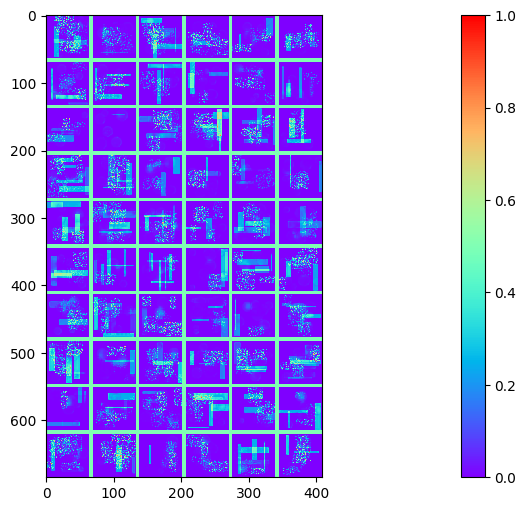

In [17]:

# Évaluation sur les données de test
test_inputs, test_targets = gen_dr_test(64)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)  # Déplacer vers le périphérique
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)  # Déplacer vers le périphérique

with torch.no_grad():
    outputs = model(test_inputs)
    outputs = torch.sigmoid(outputs)  # Appliquer une fonction sigmoïde pour obtenir des probabilités

# Affichage des résultats
fig = plt.figure(figsize=(36, 6))
voir_batch2D(outputs.cpu(), 6, fig, k=0, min_scale=0, max_scale=1)  # Déplacer vers le CPU pour affichage


Observation : Les performances sur les données de test seront probablement moins bonnes que sur les données d'entraînement en raison de la différence de distribution entre les deux ensembles.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

Une méthode simple pour améliorer les performances serait d'utiliser une technique d'adaptation de domaine telle que Fine-Tuning ou Domain-Adversarial Training (DANN). Cela permettrait au modèle de s'adapter aux caractéristiques spécifiques des données de test.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).

**Nature du problème :** L'article aborde le problème de segmentation d'images biomédicales, où l'objectif est de segmenter des structures spécifiques dans des images médicales (par exemple, des cellules, des organes, etc.).

**Méthodes d'augmentation de données :** Les auteurs utilisent des techniques d'augmentation de données telles que des rotations, des déformations élastiques et des changements de contraste pour augmenter la taille et la diversité du jeu de données.

**Déséquilibre entre les classes :** Le déséquilibre entre les classes est dû à la présence de beaucoup plus de pixels de fond que de pixels d'intérêt (par exemple, les cellules). Pour traiter ce problème, les auteurs utilisent une fonction de perte pondérée qui donne plus d'importance aux pixels des classes minoritaires.